In [57]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [11]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io
from scipy.spatial.transform import Rotation as R

# Conver full coverage of 5a1a to quarter knowing the symmetries

In [58]:
data_dir = "../../data/RESULTS_PIPELINE_5a1a"

# half coverage (AngCoverage=0.5)
projections_filename = f"5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [59]:
projections = data['Projections']
projections.shape

(5000, 275, 275)

In [60]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

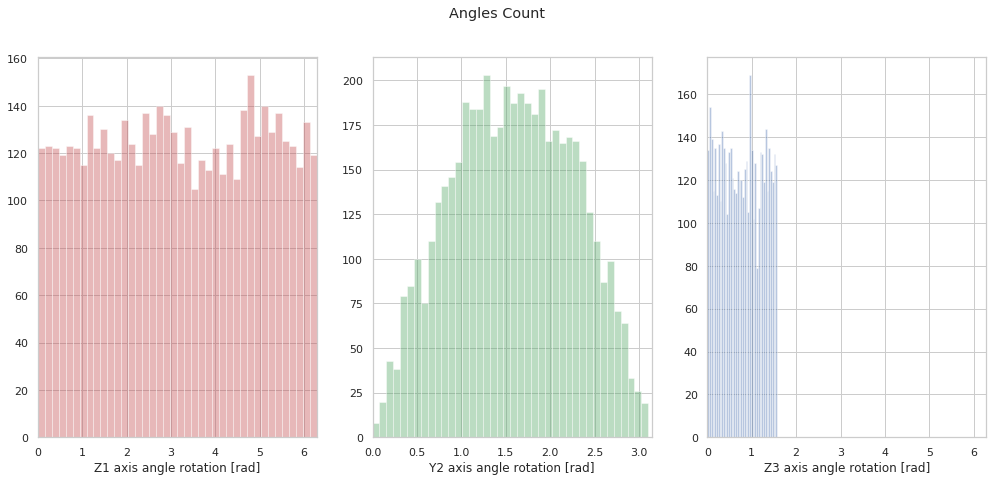

In [61]:
plot_angles_count(angles_true)

In [62]:
from cryoem.plots import plot_detector_pixels
import mrcfile
from cryoem.rotation_matrices import RotationMatrix

In [63]:
from cryoem.rotation_matrices import RotationMatrix
def plot_detector_pixels(angles, reconstruction, center=np.array([100, 155/2, 199/4])):
    
    
    # NOTE: used
    ipv.clear()

    arr = RotationMatrix(angles)

    ipv.figure(width=500, height=500)
    ipv.volshow(reconstruction, level=[0.1, 0.1], opacity=0.2,  data_min=reconstruction.min(), data_max=reconstruction.max())
    
    radius = np.max(reconstruction.shape)/1.5

    ipv.scatter(center[0]+arr[:, 0]*radius, 
                center[1]+arr[:, 1]*radius, 
                center[2]+arr[:, 2]*radius, 
                marker="sphere", color="blue", size=1)
    ipv.xlim(center[0]-radius, center[0]+radius)
    ipv.ylim(center[1]-radius, center[1]+radius)
    ipv.zlim(center[2]-radius, center[2]+radius)
    ipv.show()

In [64]:
input_file_path = "../../data/5a1a.mrc"
with mrcfile.open(input_file_path) as mrcVol:
    reconstruction = np.array(mrcVol.data) 

plot_detector_pixels(angles_true, reconstruction)

In [25]:
angles_true.shape

(5000, 3)

In [26]:
data_dir = "../../data/results_pipeline_5a1a_quartercov_uniformS2_noise0"

# half coverage (AngCoverage=0.5)
projections_filename = f"5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.4_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

angles_true_quarter = np.array(data['Angles'])

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [27]:
# true = R.from_euler('zyz', angles_true_quarter)
# rot = R.from_euler('xyz', [np.pi, 0, 0])
# q = true  * rot

# _angles = q.as_euler('zyz', degrees=False)

_angles = np.zeros(angles_true.shape)
for i, a in enumerate(angles_true_quarter):
    # 1st quarter
    #_angles[i] = [a[0], a[1], a[2]]  
    # 2nd quarter
    true = R.from_euler('zyz', a)
    rot = R.from_euler('xyz', [np.pi, 0, 0])
    q = true  * rot
    _angles[i] = q.as_euler('zyz')
    _angles[i] = [_angles[i][0]%(2*np.pi), _angles[i][1]%(np.pi), -_angles[i][2]%(2*np.pi)]
    
    # 3rd quarter
    #_angles[i] = [a[0], a[1], a[2]-np.pi]  
    
    #_4th quarter
#     true = R.from_euler('zyz', a)
#     rot = R.from_euler('xyz', [np.pi, 0, 0])
#     q = true  * rot
#     _angles[i] = q.as_euler('zyz')
#     _angles[i] = [_angles[i][0]%(2*np.pi), _angles[i][1]%(np.pi), np.pi-(_angles[i][2]%(2*np.pi))]
    

In [28]:
angles_true_quarter

array([[0.        , 0.        , 0.        ],
       [1.9063005 , 0.94864184, 0.3551012 ],
       [0.9049026 , 2.2576249 , 0.28577644],
       ...,
       [3.0515776 , 1.222584  , 1.0785215 ],
       [4.650877  , 0.37622792, 1.051374  ],
       [2.569512  , 0.80991656, 0.722459  ]], dtype=float32)

In [29]:
_angles

array([[3.14159265, 0.        , 0.        ],
       [4.37688476, 2.19295082, 2.78649146],
       [5.37828273, 0.88396779, 2.85581622],
       ...,
       [3.23160774, 1.91900864, 2.06307116],
       [1.63230831, 2.76536474, 2.0902187 ],
       [3.71367342, 2.3316761 , 2.41913364]])

In [30]:
plot_detector_pixels(angles_true_quarter, reconstruction)

In [31]:
plot_detector_pixels(_angles, reconstruction)

In [54]:
data_dir = "../../data/results_pipeline_5a1a_quartercov_uniformS2_halfInplane"

# half coverage (AngCoverage=0.5)
projections_filename = f"5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage1.0,0.4,1.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

angles_true_quarter = np.array(data['Angles'])

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [55]:
plot_detector_pixels(angles_true_quarter, reconstruction)

In [56]:
plot_rotvec(angles_true_quarter)

[8.42936970e-08 1.91215648e+00 1.49732779e+00 ... 2.03157213e+00
 3.05739435e+00 1.02238875e+00]


In [32]:
angles_true_transformed = np.zeros(angles_true.shape)
for i, a in enumerate(angles_true):
    new_a2 = a[2]
    # 1st quarter
    if 0 <= new_a2 <= np.pi/2:
        angles_true_transformed[i] = [a[0], a[1], a[2]]
    
    # 2nd quarter
    if np.pi/2 <= new_a2 <= np.pi:
        true = R.from_euler('zyz', a)
        rot = R.from_euler('xyz', [np.pi, 0, 0])
        q = true  * rot
        angles_true_transformed[i] = q.as_euler('zyz')
        angles_true_transformed[i] = [angles_true_transformed[i][0]%(2*np.pi), 
                                      angles_true_transformed[i][1]%(np.pi), 
                                      -angles_true_transformed[i][2]%(2*np.pi)]
    
    # 3rd quarter
    if np.pi < new_a2 <= 3/2*np.pi:  # opposite is the same
        angles_true_transformed[i] = [a[0], a[1], a[2]-np.pi]

    if 3/2*np.pi <= new_a2 <= 2*np.pi:
        true = R.from_euler('zyz', a)
        rot = R.from_euler('xyz', [np.pi, 0, 0])
        q = true  * rot
        angles_true_transformed[i] = q.as_euler('zyz')
        angles_true_transformed[i] = [angles_true_transformed[i][0]%(2*np.pi), 
                                      angles_true_transformed[i][1]%(np.pi), 
                                      np.pi-angles_true_transformed[i][2]%(2*np.pi)]
    
    #angles_true_transformed[i] = [a[0], a[1], a[2]]
    

In [33]:
plot_detector_pixels(angles_true_transformed, reconstruction)

In [39]:
from cryoem.plots import plot_rotvec, plot_polar_plot

In [42]:
plot_rotvec(angles_true)

[7.88495335e-08 2.67610773e+00 2.30924946e+00 ... 1.09372308e+00
 2.83464811e+00 1.70114409e+00]


In [38]:
plot_rotvec(angles_true_transformed)

[7.88495335e-08 1.32967648e+00 3.06720468e+00 ... 1.09372302e+00
 2.13203717e+00 2.40105393e+00]


In [41]:
plot_polar_plot(angles_true)

In [40]:
plot_polar_plot(angles_true_transformed)

In [9]:
#np.save("angles_true_transformed.npy", angles_true_transformed)

In [7]:
data = np.load(f"5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [8]:
input_file_path = "../../data/5a1a.mrc"

from cryoem.reconstruction import reconstruct

angles_true_transformed = np.load("angles_true_transformed.npy")

reconstruction = reconstruct(projections[test_idx], 
                             angles_true_transformed[test_idx], 
                             mrc_filename=f"test_gt.mrc", 
                             initial_mrc_filename=input_file_path, 
                             overwrite=True)

Vol shape: [110, 155, 199]
Reconstruction voxel size: (1., 1., 1.)
Initial voxel size: (1., 1., 1.)
Header:
	mrc.header.cella: (199., 155., 110.)
	mrc.header.cellb: (90., 90., 90.)
	mrc.header.origin: (-6.429, 15.82, 38.103)
	mrc.header.ispg: 0
Reconstruction saved to: test_gt.mrc


---

In [3]:
data_dir = "../../data/results_pipeline_5j0n_fullcvg_uniformS2_noise0"

# half coverage (AngCoverage=0.5)
projections_filename = f"5j0n_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [5]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

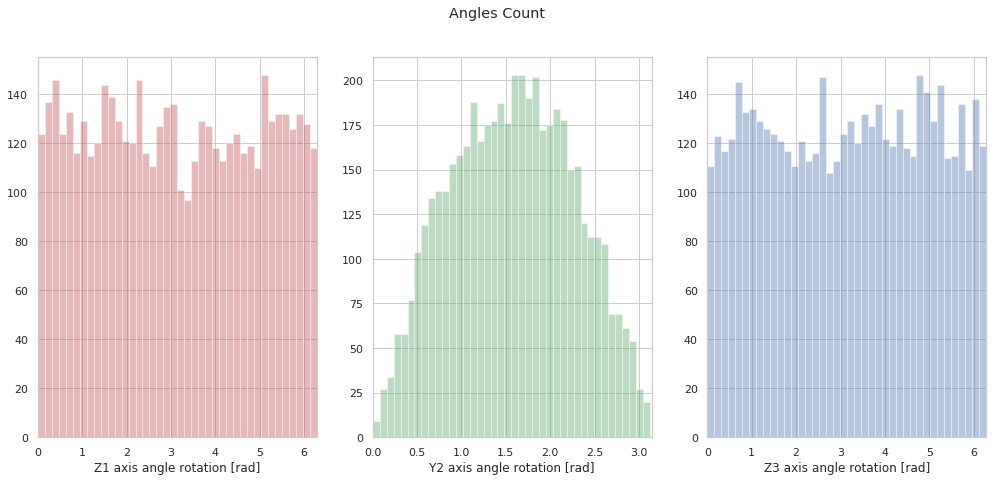

In [6]:
plot_angles_count(angles_true)

In [7]:
from cryoem.preprocessing import global_standardization

X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)
X = global_standardization(X)
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

	Global standardization
		Image shape: (116, 116)
		Data Type: float32
		Mean: 0.262 | Std: 1.020
		Min:  0.000 | Max: 15.280
		Mean: 0.000 | Std: 1.000
		Min:  -0.257 | Max: 14.719


In [8]:
data = np.load(f"{data_dir}/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [9]:
angles_predicted = np.load(f"{data_dir}/angles_predicted.npy")

In [10]:
angles_predicted

array([[ 2.38848711,  0.42261197, -1.37807695],
       [-0.74516957,  1.58298598, -2.28581924],
       [-0.93505456,  1.80815396,  0.41650356],
       ...,
       [ 2.59411078,  1.21049611, -2.41898506],
       [-1.6318815 ,  1.23993378, -0.92315745],
       [ 2.41536856,  1.83498411,  1.88521979]])

In [11]:
# from cryoem.conversions import quaternion2euler

In [12]:
# data = np.load(f"{data_dir}/angle_recovery.npz")
# q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

# angles_predicted = quaternion2euler(q_predicted).numpy()

In [13]:
# np.save(f"{data_dir}/angles_predicted", angles_predicted)

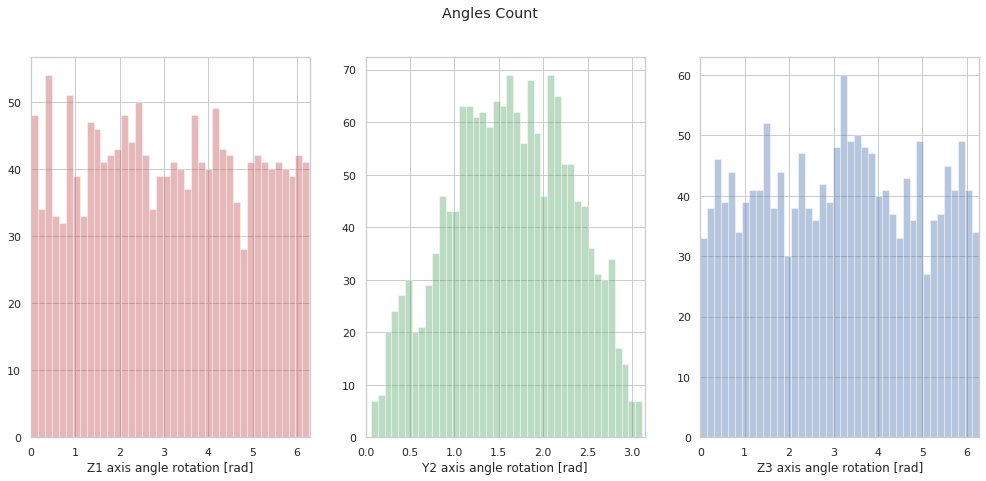

In [14]:
plot_angles_count(angles_predicted)

In [16]:
# import ipyvolume as ipv
# from matplotlib.colors import ListedColormap
# from matplotlib import cm



    
# from cryoem.rotation_matrices import RotationMatrix
# from scipy.spatial.transform import Rotation as R
# import ipyvolume as ipv
# from matplotlib.colors import ListedColormap
# from matplotlib import cm

# def plot_rotvec(angles, projections=None, d_p=None, point_size=2):
#     if projections is None:
#         angle_ref = angles[0]
#         distances = d_q(euler2quaternion(angle_ref), euler2quaternion(angles)).numpy() #[]
#     else:
#         projection_ref = projections[0]
#         print(projection_ref.shape)
#         distances = d_p(np.broadcast_to(projection_ref, (len(projections), *projection_ref.shape[-2:])), projections).flatten() #[]
#     cmap = plt.cm.get_cmap('viridis', 3)
#     #newcmp = ListedColormap(distances)
#     colors = list(map(lambda x: cmap(x),distances))
#     print(distances)
    
#     colormap = cm.coolwarm
#     dist_min = 0
#     dist_max = np.pi
#     znorm = distances - dist_min #distances.min()
#     znorm /= (dist_max - dist_min) #znorm.ptp()
#     #znorm.min(), znorm.max()
#     color = colormap(znorm)  
    
    
    
    
#     a = R.from_euler('zyz', angles).as_rotvec()

#     ipv.figure()
#     ipv.scatter(a[:, 0], a[:, 1], a[:, 2],
#                 marker="sphere", color=color[...,:3], size=point_size)
#     ipv.scatter(a[0:1, 0], a[0:1, 1], a[0:1, 2],
#                 marker="sphere", color="black", size=5)
#     ipv.xlim(-np.pi, np.pi)
#     ipv.ylim(-np.pi, np.pi)
#     ipv.zlim(-np.pi, np.pi)
#     ipv.show()

In [17]:
plot_rotvec(angles_true[test_idx])

[7.88495335e-08 2.64460649e+00 3.08582178e+00 ... 1.19665648e+00
 2.49165879e+00 3.05190907e+00]


In [20]:
plot_rotvec(angles_predicted)

[8.42936970e-08 2.67152399e+00 2.53479213e+00 ... 1.17671231e+00
 2.65116660e+00 3.03753676e+00]


In [23]:
angles_true[test_idx]

array([[1.92120624, 0.81988531, 3.99839694],
       [5.84660954, 1.4883368 , 1.47769284],
       [3.56307704, 1.99647737, 0.34849009],
       ...,
       [0.43099254, 0.87390625, 4.52476281],
       [4.21404535, 1.75121439, 1.22390723],
       [5.16841799, 2.27705145, 4.75277681]])

In [24]:
angles_predicted

array([[2.38848711, 0.42261197, 4.90510836],
       [5.53801574, 1.58298598, 3.99736606],
       [5.34813075, 1.80815396, 0.41650356],
       ...,
       [2.59411078, 1.21049611, 3.86420025],
       [4.65130381, 1.23993378, 5.36002786],
       [2.41536856, 1.83498411, 1.88521979]])

In [27]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

m= [1.0, 1.0, 1.0, 1.0] 
trajectory_first= [6.06726793 3.189466   6.1805537  1.91378781 3.53678175 5.98015236] 
loss_first= 2.1842304298734283 
trajectory_last= [  4.73975982  39.88423483 -12.5800033  -10.55176968 -18.5074087
  35.502916  ] 
loss_last= 0.23740604787952474


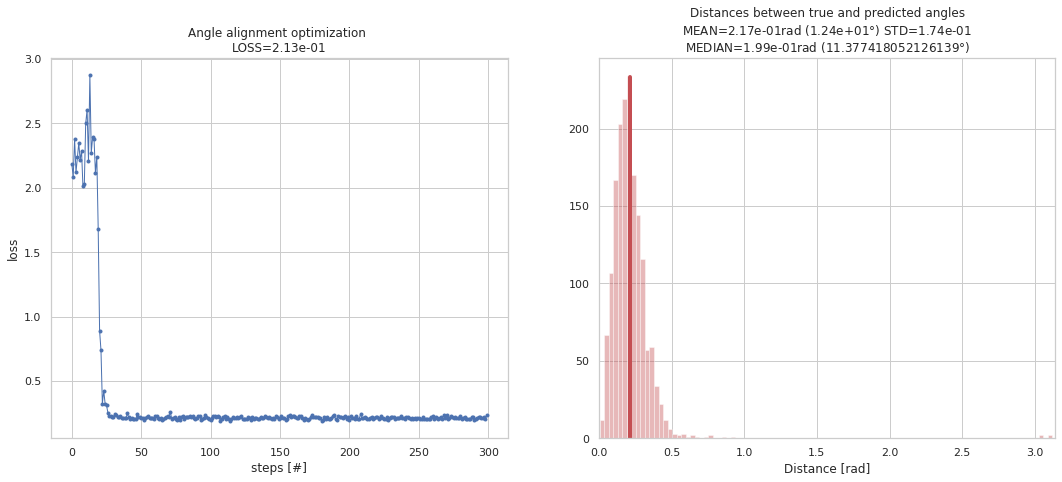

In [28]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true[test_idx], 
                                                        angles_predicted=angles_predicted)

[4.73975982, 39.88423483, -12.5800033, -10.55176968, -18.5074087, 35.502916]
[4.73975982, 2.1851229869224795, 6.269552621538759, 2.014600934359173, 0.34214722153875954, 4.086989464102068]


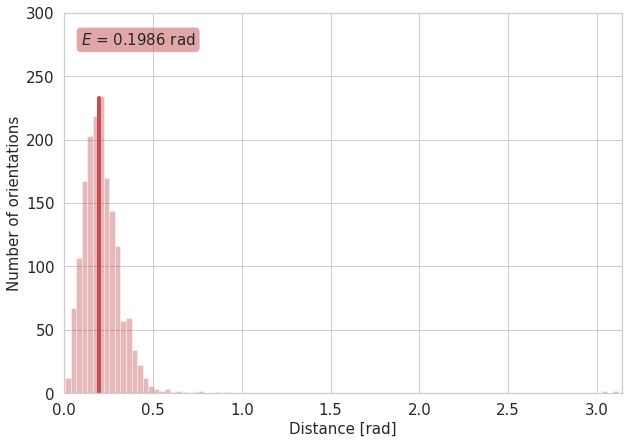

In [47]:
trajectory_last= [  4.73975982 , 39.88423483, -12.5800033,  -10.55176968, -18.5074087, 35.502916  ] 
print(trajectory_last)
trajectory_last = list(map(lambda x: x%(2*np.pi), trajectory_last))
print(trajectory_last)
tick_size = 15
label_size = 15

fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 300)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5j0n_noise16_angle_alignment_after.pdf")
plt.show()

In [30]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

In [31]:
plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=200, connections=False, selected=None)

In [35]:
plot_iterations_rotvec(collect_data, angles_true[test_idx], interval=1500)

In [37]:
plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=1500, connections=False, selected=None)

---

In [3]:
import astra

In [6]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import get_writer
 
import astra
 
# Configuration.
distance_source_origin = 300  # [mm]
distance_origin_detector = 100  # [mm]
detector_pixel_size = 1.05  # [mm]
detector_rows = 200  # Vertical size of detector [pixels].
detector_cols = 200  # Horizontal size of detector [pixels].
num_of_projections = 180
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)
output_dir = 'dataset'
 
# Create phantom.
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                          detector_rows)
phantom = np.zeros((detector_rows, detector_cols, detector_cols))
hb = 110  # Height of beam [pixels].
wb = 40   # Width of beam [pixels].
hc = 100  # Height of cavity in beam [pixels].
wc = 30   # Width of cavity in beam [pixels].
phantom[detector_rows // 2 - hb // 2 : detector_rows // 2 + hb // 2,
        detector_cols // 2 - wb // 2 : detector_cols // 2 + wb // 2,
        detector_cols // 2 - wb // 2 : detector_cols // 2 + wb // 2] = 1
phantom[detector_rows // 2 - hc // 2 : detector_rows // 2 + hc // 2,
        detector_cols // 2 - wc // 2 : detector_cols // 2 + wc // 2,
        detector_cols // 2 - wc // 2 : detector_cols // 2 + wc // 2] = 0
phantom[detector_rows // 2 - 5 :       detector_rows // 2 + 5,
        detector_cols // 2 + wc // 2 : detector_cols // 2 + wb // 2,
        detector_cols // 2 - 5 :       detector_cols // 2 + 5] = 0
phantom_id = astra.data3d.create('-vol', vol_geom, data=phantom)
 
# Create projections. With increasing angles, the projection are such that the
# object is rotated clockwise. Slice zero is at the top of the object. The
# projection from angle zero looks upwards from the bottom of the slice.
proj_geom = \
  astra.create_proj_geom('cone', 1, 1, detector_rows, detector_cols, angles,
                         (distance_source_origin + distance_origin_detector) /
                         detector_pixel_size, 0)
projections_id, projections = \
  astra.creators.create_sino3d_gpu(phantom_id, proj_geom, vol_geom)
projections /= np.max(projections)
 
# Apply Poisson noise.
projections = np.random.poisson(projections * 10000) / 10000
projections[projections > 1.1] = 1.1
projections /= 1.1
 
# Save projections.
if not isdir(output_dir):
    mkdir(output_dir)
projections = np.round(projections * 65535).astype(np.uint16)
for i in range(num_of_projections):
    projection = projections[:, i, :]
    with get_writer(join(output_dir, 'proj%04d.tif' %i)) as writer:
        writer.append_data(projection, {'compress': 9})

# Cleanup.
astra.data3d.delete(projections_id)
astra.data3d.delete(phantom_id)

In [11]:
projections.shape

(200, 180, 200)

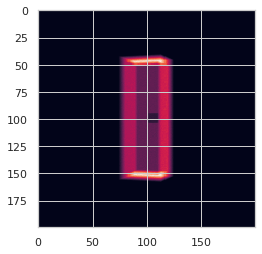

In [13]:
plt.imshow(projections[:,10,:])

In [19]:
from __future__ import division
 
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
import mrcfile
import astra
 
# Configuration.
distance_source_origin = 300  # [mm]
distance_origin_detector = 100  # [mm]
detector_pixel_size = 1.05  # [mm]
detector_rows = 200  # Vertical size of detector [pixels].
detector_cols = 200  # Horizontal size of detector [pixels].
num_of_projections = 180
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False) + 2
input_dir = 'dataset'
output_dir = 'reconstruction'
 
# Load projections.
projections = np.zeros((detector_rows, num_of_projections, detector_cols))
for i in range(num_of_projections):
    im = imread(join(input_dir, 'proj%04d.tif' % i)).astype(float)
    im /= 65535
    projections[:, i, :] = im

# Copy projection images into ASTRA Toolbox.
proj_geom = \
  astra.create_proj_geom('cone', 1, 1, detector_rows, detector_cols, angles,
                         (distance_source_origin + distance_origin_detector) /
                         detector_pixel_size, 0)
projections_id = astra.data3d.create('-sino', proj_geom, projections)
 
# Create reconstruction.
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                          detector_rows)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
alg_cfg = astra.astra_dict('FDK_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)
astra.algorithm.run(algorithm_id)
reconstruction = astra.data3d.get(reconstruction_id)
 
# Limit and scale reconstruction.
reconstruction[reconstruction < 0] = 0
reconstruction /= np.max(reconstruction)
reconstruction = np.round(reconstruction * 255).astype(np.uint8)
 
# Save reconstruction.
if not isdir(output_dir):
    mkdir(output_dir)
for i in range(detector_rows):
    im = reconstruction[i, :, :]
    im = np.flipud(im)
    imwrite(join(output_dir, 'reco2-%04d.png' % i), im)

# Cleanup.
astra.algorithm.delete(algorithm_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(projections_id)

mrc_filename = join(output_dir, 'phantom2.mrc')
#Path(output_dir).parent.mkdir(parents=True, exist_ok=True)
with mrcfile.new(mrc_filename, overwrite=True) as mrc:
    mrc.set_data(reconstruction)

---

In [15]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import get_writer
from cryoem.rotation_matrices import RotationMatrix
import astra
 
# Configuration.
distance_source_origin = 300  # [mm]
distance_origin_detector = 100  # [mm]
detector_pixel_size = 1.05  # [mm]
detector_rows = 200  # Vertical size of detector [pixels].
detector_cols = 200  # Horizontal size of detector [pixels].


# _angles = np.zeros((num_of_projections, 3))  #np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)
# for i, a in enumerate(np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)):
#     _angles[i] = [np.pi/2, np.pi/2,a]
_angles = angles_true[test_idx].copy()

angles = RotationMatrix(_angles)  

num_of_projections = len(_angles)
output_dir = 'dataset_full'
 
# Create phantom.
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                          detector_rows)
phantom = np.zeros((detector_rows, detector_cols, detector_cols))
hb = 110  # Height of beam [pixels].
wb = 40   # Width of beam [pixels].
hc = 100  # Height of cavity in beam [pixels].
wc = 30   # Width of cavity in beam [pixels].
phantom[detector_rows // 2 - hb // 2 : detector_rows // 2 + hb // 2,
        detector_cols // 2 - wb // 2 : detector_cols // 2 + wb // 2,
        detector_cols // 2 - wb // 2 : detector_cols // 2 + wb // 2] = 1
phantom[detector_rows // 2 - hc // 2 : detector_rows // 2 + hc // 2,
        detector_cols // 2 - wc // 2 : detector_cols // 2 + wc // 2,
        detector_cols // 2 - wc // 2 : detector_cols // 2 + wc // 2] = 0
phantom[detector_rows // 2 - 5 :       detector_rows // 2 + 5,
        detector_cols // 2 + wc // 2 : detector_cols // 2 + wb // 2,
        detector_cols // 2 - 5 :       detector_cols // 2 + 5] = 0
phantom_id = astra.data3d.create('-vol', vol_geom, data=phantom)
 
# Create projections. With increasing angles, the projection are such that the
# object is rotated clockwise. Slice zero is at the top of the object. The
# projection from angle zero looks upwards from the bottom of the slice.
# proj_geom = \
#   astra.create_proj_geom('cone', 1, 1, detector_rows, detector_cols, angles,
#                          (distance_source_origin + distance_origin_detector) /
#                          detector_pixel_size, 0)
proj_geom = astra.create_proj_geom('parallel3d_vec', detector_rows, detector_cols, angles)

projections_id, projections = \
  astra.creators.create_sino3d_gpu(phantom_id, proj_geom, vol_geom)
projections /= np.max(projections)
 
# Apply Poisson noise.
projections = np.random.poisson(projections * 10000) / 10000
projections[projections > 1.1] = 1.1
projections /= 1.1
 
# Save projections.
if not isdir(output_dir):
    mkdir(output_dir)
projections = np.round(projections * 65535).astype(np.uint16)
for i in range(num_of_projections):
    projection = projections[:, i, :]
    with get_writer(join(output_dir, 'proj%04d.tif' %i)) as writer:
        writer.append_data(projection, {'compress': 9})

# Cleanup.
astra.data3d.delete(projections_id)
astra.data3d.delete(phantom_id)

In [19]:
angles_true[test_idx]

array([[1.92120624, 0.81988531, 3.99839694],
       [5.84660954, 1.4883368 , 1.47769284],
       [3.56307704, 1.99647737, 0.34849009],
       ...,
       [0.43099254, 0.87390625, 4.52476281],
       [4.21404535, 1.75121439, 1.22390723],
       [5.16841799, 2.27705145, 4.75277681]])

In [17]:
angles_predicted

array([[2.38848711, 0.42261197, 4.90510836],
       [5.53801574, 1.58298598, 3.99736606],
       [5.34813075, 1.80815396, 0.41650356],
       ...,
       [2.59411078, 1.21049611, 3.86420025],
       [4.65130381, 1.23993378, 5.36002786],
       [2.41536856, 1.83498411, 1.88521979]])

In [100]:
from scipy.spatial.transform import Rotation as R

true = R.from_euler('zyz', angles_true[test_idx])
rot = R.from_euler('zyz', [0, 0, 0])
q = true  * rot

_angles = q.as_euler('zyz', degrees=False)

In [101]:
from cryoem.plots import plot_rotvec,plot_detector_pixels,plot_only_selected_in_euclidean_space

In [102]:
plot_only_selected_in_euclidean_space(angles_true[test_idx], _angles, range(5))

In [103]:
_angles.max()

3.1399989128112793

In [104]:
from __future__ import division
 
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
import mrcfile
import astra
 
# Configuration.
distance_source_origin = 300  # [mm]
distance_origin_detector = 100  # [mm]
detector_pixel_size = 1.05  # [mm]
detector_rows = 200  # Vertical size of detector [pixels].
detector_cols = 200  # Horizontal size of detector [pixels].

#angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False) + 2
# _angles = np.zeros((num_of_projections, 3))  #np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)
# for i, a in enumerate(np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)):
#     _angles[i] = [np.pi/2, np.pi/2,a]
#_angles = angles_true[test_idx].copy() 
# for i, a in enumerate(_angles):
#     _angles[i] = [a[0], a[1]+1, a[2]+2]
#_angles = angles_predicted.copy()

angles = RotationMatrix(_angles)    

num_of_projections = len(angles)

input_dir = 'dataset_full'
output_dir = 'reconstruction_full'
 
# Load projections.
projections = np.zeros((detector_rows, num_of_projections, detector_cols))
for i in range(num_of_projections):
    im = imread(join(input_dir, 'proj%04d.tif' % i)).astype(float)
    im /= 65535
    projections[:, i, :] = im

# Copy projection images into ASTRA Toolbox.
# proj_geom = \
#   astra.create_proj_geom('cone', 1, 1, detector_rows, detector_cols, angles,
#                          (distance_source_origin + distance_origin_detector) /
#                          detector_pixel_size, 0)
proj_geom = astra.create_proj_geom('parallel3d_vec', detector_rows, detector_cols, angles)

projections_id = astra.data3d.create('-sino', proj_geom, projections)
 
# Create reconstruction.
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols, detector_rows)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)

alg_cfg = astra.astra_dict('CGLS3D_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)
astra.algorithm.run(algorithm_id, 100)
reconstruction = astra.data3d.get(reconstruction_id)
 
# Limit and scale reconstruction.
reconstruction[reconstruction < 0] = 0
reconstruction /= np.max(reconstruction)
reconstruction = np.round(reconstruction * 255).astype(np.uint8)
 
# Save reconstruction.
if not isdir(output_dir):
    mkdir(output_dir)
for i in range(detector_rows):
    im = reconstruction[i, :, :]
    im = np.flipud(im)
    imwrite(join(output_dir, 'reco%04d.png' % i), im)

# Cleanup.
astra.algorithm.delete(algorithm_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(projections_id)

mrc_filename = join(output_dir, 'phantom-full.mrc')
#Path(output_dir).parent.mkdir(parents=True, exist_ok=True)
with mrcfile.new(mrc_filename, overwrite=True) as mrc:
    mrc.set_data(reconstruction)

In [97]:
mrc_filename

'reconstruction_full/phantom-full.mrc'

In [179]:
def plot_detector_pixels(angles, reconstruction):
    # NOTE: used
    ipv.clear()

    if isinstance(angles[0], tf.Variable):
        angles = np.array([a.numpy() for a in angles])

    arr = RotationMatrix(angles)

    ipv.figure(width=500, height=500)
    ipv.volshow(reconstruction, level=[1, 1], opacity=0.2,  data_min=reconstruction.min(), data_max=reconstruction.max())

    ipv.scatter(reconstruction.shape[0]/2+arr[:, 0]*reconstruction.shape[0]/2, 
                reconstruction.shape[1]/2+arr[:, 1]*reconstruction.shape[0]/2, 
                reconstruction.shape[2]/2+arr[:, 2]*reconstruction.shape[0]/2, 
                marker="sphere", color="blue", size=1)

    ipv.show()

In [180]:
reconstruction.shape

(200, 200, 200)

In [181]:
plot_detector_pixels(angles_true, reconstruction)

[ 94.50480169 225.95116532 138.57599664 ... 141.40930565 133.10886866
 193.85627855]


---

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import h5py
import numpy as np

import os, sys
sys.path.append("../..")
from cryoem.projections import *
from cryoem.conversions import d_q, euler2quaternion
import sys
sys.path.append("..") 
from cryoem.projections import generate_2D_projections
from cryoem.plots import plot_projection, plot_detector_pixels, plot_angles_count
from cryoem.preprocessing import preprocessing, train_val_test_split
from cryoem.distance_estimation import train_distance_estimation
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl, Adam
from cryoem.conversions import quaternion2euler
import matplotlib.pyplot as plt
from cryoem.conversions import d_q, euler2quaternion
from cryoem.reconstruction import reconstruct
from cryoem.plots import plot_dP_dQ
import h5py
import ipyvolume as ipv
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow.python.client import device_lib 
# from numba import cuda
tf.__version__

'2.0.0'

### Read ground_truth angles and projecitions

In [3]:
# location of *.h5 files
#data_dir = "../../data/"

# half coverage (AngCoverage=0.5)
projections_filename = "5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(projections_filename, 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
angles_true = np.array(data['Angles'])
angles_true

array([[0.        , 0.        , 0.        ],
       [5.903202  , 1.2331519 , 0.12148807],
       [6.1756244 , 1.4069097 , 4.7811775 ],
       ...,
       [5.6801696 , 2.2910209 , 4.3940897 ],
       [1.779877  , 1.6752067 , 1.9843652 ],
       [5.3252997 , 2.623892  , 3.5539036 ]], dtype=float32)

In [5]:
projections = np.array(data["Projections"])
projections.shape

(5000, 275, 275)

In [6]:
from cryoem.preprocessing import global_standardization

In [7]:
def add_gaussian_noise(projections, noise_var):
    noise_sigma   = noise_var**0.5
    nproj,row,col = projections.shape
    gauss_noise   = np.random.normal(0,noise_sigma,(nproj,row,col))
    gauss_noise   = gauss_noise.reshape(nproj,row,col) 
    projections   = projections + gauss_noise
    return projections
NOISY_VAR = 0
# Add zero-mean Gaussian noise on the projections 
projections = add_gaussian_noise(projections, NOISY_VAR)
#projections = add_triangle_translation(projections, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION)


from skimage.transform import resize

dim = 116

projections_new = np.zeros((len(projections), dim, dim))
for i in range(5000):
    p = projections[i]
    p = resize(p, (dim, dim))
    projections_new[i] = p

projections = projections_new.copy()

X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)
X = global_standardization(X)
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

	Global standardization
		Image shape: (116, 116)
		Data Type: float32
		Mean: 2.955 | Std: 7.724
		Min:  0.000 | Max: 75.357
		Mean: -0.000 | Std: 1.000
		Min:  -0.383 | Max: 9.374


In [8]:
data = np.load(f"5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

a = test_idx[0]
test_idx[0] = 0
val_idx[0] = a
val_idx = np.sort(val_idx)

In [9]:
angles_true[test_idx]

array([[0.       , 0.       , 0.       ],
       [1.0722375, 1.6458324, 5.9881206],
       [4.292709 , 2.6484997, 3.3814101],
       ...,
       [1.629    , 1.2693031, 3.1592505],
       [1.779877 , 1.6752067, 1.9843652],
       [5.3252997, 2.623892 , 3.5539036]], dtype=float32)

### Read angles predicted with almost perfect $L_{OR}$

In [10]:
angles_predicted = np.array(np.load("angles_predicted.npy"), dtype=np.float32)

In [11]:
angles_predicted

array([[-0.99652225,  0.4690642 , -3.0061533 ],
       [-0.46788064,  0.94901377,  2.373763  ],
       [-0.4177783 ,  1.0960375 ,  1.8538426 ],
       ...,
       [ 0.62812924,  0.712974  ,  1.6086097 ],
       [ 2.536145  ,  0.40164217, -0.3002845 ],
       [-1.875753  ,  0.33388653, -1.8732475 ]], dtype=float32)

In [12]:
# input_file_path = "../../data/5a1a.mrc"
# ProjNber = len(angles_predicted)
# #AngCoverage = [1.0, 1.0, 2.0]
# #AngShift = [0, 0, 0]
# output_file_name = "5a1a_angles_predicted_projections.h5"

# generate_2D_projections(input_file_path=input_file_path, 
#                         ProjNber=ProjNber,
#                         AngCoverage=None,
#                         AngShift=None,
#                         Angles=angles_predicted,
#                         angles_gen_mode=None,
#                         output_file_name=output_file_name)

In [13]:
import ipyvolume as ipv
from matplotlib.colors import ListedColormap
from matplotlib import cm


def plot_detector_pixels(angles, projections=None, d_p=None):
    if projections is None:
        angle_ref = angles[0]
        distances = d_q(euler2quaternion(angle_ref), euler2quaternion(angles)).numpy() #[]
    else:
        projection_ref = projections[0]
        print(projection_ref.shape)
        distances = d_p(np.broadcast_to(projection_ref, (len(projections), *projection_ref.shape[-2:])), projections).flatten() #[]
    
    cmap = plt.cm.get_cmap('viridis', 3)
    #newcmp = ListedColormap(distances)
    colors = list(map(lambda x: cmap(x),distances))
    print(distances)
    
#     for a in angles:
#         distances.append(d_q(euler2quaternion(angle_ref), euler2quaternion(a)))
        
    #
    colormap = cm.coolwarm
    znorm = distances - distances.min()
    znorm /= znorm.ptp()
    znorm.min(), znorm.max()
    color = colormap(znorm)  
    
    # NOTE: used
    ipv.clear()

    if isinstance(angles[0], tf.Variable):
        angles = np.array([a.numpy() for a in angles])

    arr = RotationMatrix(angles)

    ipv.figure(width=500, height=500)
    
    s = ipv.scatter(arr[:, 0], arr[:, 1], arr[:, 2],
                marker="sphere", color=color[...,:3], size=3)
    s = ipv.scatter(arr[0:1, 0], arr[0:1, 1], arr[0:1, 2],
                marker="sphere", color="black", size=5)
    ipv.xlim(-1, 1)
    ipv.ylim(-1, 1)
    ipv.zlim(-1, 1)
    ipv.show()
    


In [14]:
from cryoem.rotation_matrices import RotationMatrix
from scipy.spatial.transform import Rotation as R

def plot_rotvec(angles, projections=None, d_p=None):
    if projections is None:
        angle_ref = angles[0]
        distances = d_q(euler2quaternion(angle_ref), euler2quaternion(angles)).numpy() #[]
    else:
        projection_ref = projections[0]
        print(projection_ref.shape)
        distances = d_p(np.broadcast_to(projection_ref, (len(projections), *projection_ref.shape[-2:])), projections).flatten() #[]
    
    cmap = plt.cm.get_cmap('viridis', 3)
    #newcmp = ListedColormap(distances)
    colors = list(map(lambda x: cmap(x),distances))
    print(distances)
    
    colormap = cm.coolwarm
    dist_min = 0
    dist_max = np.pi
    znorm = distances - dist_min #distances.min()
    znorm /= (dist_max - dist_min) #znorm.ptp()
    #znorm.min(), znorm.max()
    color = colormap(znorm)  
    
    
    
    
    a = R.from_euler('zyz', angles).as_rotvec()

    ipv.figure()
    ipv.scatter(a[:, 0], a[:, 1], a[:, 2],
                marker="sphere", color=color[...,:3], size=2)
    ipv.scatter(a[0:1, 0], a[0:1, 1], a[0:1, 2],
                marker="sphere", color="black", size=5)
    ipv.xlim(-np.pi, np.pi)
    ipv.ylim(-np.pi, np.pi)
    ipv.zlim(-np.pi, np.pi)
    ipv.show()

In [1]:
plot_detector_pixels(angles_true)

NameError: name 'plot_detector_pixels' is not defined

In [ ]:
plot_rotvec(angles_true)

In [ ]:
plot_detector_pixels(angles_predicted)

In [ ]:
plot_rotvec(angles_predicted)

In [ ]:
#import tensorflow_probability as tfp
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.rotation_matrices import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model#, multi_gpu_model
#from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.losses import KLD, MAE, MSE

_idx1 = list(np.random.choice(val_idx, size=1000))
_idx2 = list(np.random.choice(val_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in _idx1])
q2_true = euler2quaternion([angles_true[i] for i in _idx2])

p1 = [X[i] for i in _idx1]
p2 = [X[i] for i in _idx2]

model = None

def cosine_distance(vests):
    x, y = vests
    xy_sum_square = K.sum(x * y, axis=1, keepdims=True) 
    xx_sum_square = K.sum(x * x, axis=1, keepdims=True)
    xx_sum_square = K.maximum(xx_sum_square,  1e-08) 
    yy_sum_square = K.sum(y * y, axis=1, keepdims=True)
    yy_sum_square = K.maximum(yy_sum_square, 1e-08) 
    
    cos_theta = tf.divide(xy_sum_square, K.sqrt(xx_sum_square)*K.sqrt(yy_sum_square))
    eps = K.epsilon()
    return 2*tf.acos(tf.clip_by_value(cos_theta, 0.0+eps, 1.0-eps)) 

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def mae(y_true, y_pred):
    return MAE(y_true, y_pred) 

def mse(y_true, y_pred):
    return MSE(y_true, y_pred) 


def create_siamese_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    #print(input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)


def read_model_from_weights(X, y, batch_size, learning_rate, weights_file, training_description="", gpus=None):
    
    
    def d_p(p1, p2):
        global model
        p1 = tf.cast(p1, dtype=tf.float32)
        p2 = tf.cast(p2, dtype=tf.float32)
        return model.predict([p1, p2], batch_size=256)

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def generate_dPdQ_plot(file_writer_plot):
        """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""

        
        def _inner_plot(epoch, logs):
            """Generate dP/dQ plot for tensorboard"""
            dP_values = d_p(p1, p2).T[0]
            dQ_values = d_q(q1_true, q2_true).numpy()

            # Creating the dataframe for SNS plot
            data = {"d_Q" : dQ_values, "d_P" : dP_values }
            df1 = pd.DataFrame(data=data)

            fig, ax = plt.subplots(figsize=(6,6));
            sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
            x = np.arange(0, np.pi);
            sns.regplot(x=x, y=x, color="k", ax=ax)
            #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
            #plt.show()
            
            # Log the confusion matrix as an image summary.
            with file_writer_plot.as_default():
                tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
        return _inner_plot

#     mirrored_strategy = tf.distribute.MirroredStrategy()

#     with mirrored_strategy.scope():

    input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
    print(f"Input images shape {input_shape}")

    # network definition
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    cnn_network = create_siamese_network(input_shape)

    # because we re-use the same instance `cnn_network`,
    # the weights of the network will be shared across the two branches
    processed_a = cnn_network(input_a)
    processed_b = cnn_network(input_b)


    distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])

    global model
    model = Model([input_a, input_b], distance)  # was m
    print(type(model))

    # train
    #model = multi_gpu_model(m, gpus=gpus)
    #model.summary()
    #plot_model(model, to_file=f"{path_logs_training}/model_plot_256d.png", expand_nested=True, show_shapes=True, show_layer_names=True)

    # training only top layers
    optimizer1 = RMSprop(learning_rate=learning_rate)
    model.compile(loss=mae, optimizer=optimizer1, metrics=[mse])
    print(type(model))

    # Recreate the exact same model, including its weights and the optimizer
    model.load_weights(weights_file)
        
    return model

In [ ]:
#model_filename = f"{data_dir}/5j0n_full_coverage_212_noisy16_NEW.h5"


model = read_model_from_weights(X, y, 
                                batch_size=256, 
                                learning_rate=1e-3, 
                                weights_file=f"5a1a_quartercvg_uniformS2_noise0_halfInplane_weights.h5", 
                                gpus=None)
    

In [ ]:
#model_filename = f"{data_dir}/5j0n_fullcvg_uniformS2_noisy0.h5"

# Recreate the exact same model, including its weights and the optimizer
#model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

In [ ]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [ ]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [ ]:
batch_size = 512
idx1 = list(np.random.choice(test_idx, size=batch_size))
idx2 = list(np.random.choice(test_idx, size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [ ]:
plot_dP_dQ(dP_values, dQ_values);